# Reservoir Computing for Covid dataset

## Conventional reservoir: predict patient condition using provided patient MS data

In [1]:
# Running a Cobra reservoir in predictve mode with a test set 
# Cobra is directly run with KOs instead of an AMN (no training set required)

import cobra
from Library.Import import *
from Library.Utilities import read_XY, LeaveXout
from Library.Utilities import svm_classifier, MLP, XGB, GP 
from Library.Utilities import bayes_classifier, decision_tree_classifier
from Library.Build_Dataset import TrainingSet, create_medium_run_cobra
from sklearn.metrics import r2_score, accuracy_score, f1_score, matthews_corrcoef

DIRECTORY = './Dataset_input/Covid/'
seed = 1
np.random.seed(seed=seed)

# Create Cobra model
name = 'Covid'
cobrafile = f'{DIRECTORY}{name}_duplicated'
mediumfile  = f'{DIRECTORY}{name}'
parameter = TrainingSet(cobraname=cobrafile, 
                        mediumname=mediumfile, 
                        method='FBA')
trainingfile = f'{DIRECTORY}{name}_train'
parameter.save(trainingfile)


# Load MS data
testfile = f'{DIRECTORY}UGA/MEDIUM'
feature, X_test, y_test_true = read_XY(testfile, nY=1, scaling='X')

# Classifier set up
niter = 3
learner = XGB # To classify based on all phenotypes
scoring_function = accuracy_score
selection = 1 # To reduce the number of features when performing Leave X out, if 0 no selectin
verbose = False


KOs = ['WT  '] # + [gene.name for gene in parameter.model.genes]
i = 0            
for ko in KOs:
    i += 1
    parameter.load(trainingfile)
    # Run cobra to get growth rate for X_test
    biomass, X = create_medium_run_cobra(parameter.model, 
                                         parameter.objective, 
                                         parameter.medium, 
                                         X_test, method='FBA', scaler=1, 
                                         genekos=[ko], verbose=verbose) 
    
    F = [r.id for r in parameter.model.reactions]
    X[X < 1e-3] = 0
    zero_columns = np.argwhere(np.all(X == 0, axis=0)).flatten()
    X = np.delete(X, zero_columns, axis=1)
    feature = np.delete(F, zero_columns, axis=0)
    acc_avr, acc_dev = 0.5, 0
    xfold = 20
    if X.shape[1]: 
        # Accuracy based on biomass
        acc_biomass_avr, acc_biomass_dev, feature = \
        LeaveXout(biomass.reshape(-1,1), y_test_true.ravel(), feature, 
                  learner=learner, scoring_function=scoring_function,  
                  xfold=xfold, niter=niter, 
                  selection=0, verbose=True)
        # Accuracy based on phenotype (X vector)
        acc_X_avr, acc_X_dev, feature = \
        LeaveXout(X, y_test_true.ravel(), feature,
                  learner=learner, scoring_function=scoring_function, 
                  xfold=xfold, niter=niter, 
                  selection=selection, verbose=True)
        
    # Printing
    print(f'KO {ko} Phenotype Size: {len(feature)}/{len(F)} '
            f'Method: {learner.__name__} Score: {scoring_function.__name__} '
            f'Acc Phenotype: {acc_X_avr:.3f}±{acc_X_dev:.3f} '
            f'Acc Biomass: {acc_biomass_avr:.3f}±{acc_biomass_dev:.3f} '
            f'for {xfold}-fold-CV and {niter} iter')
    if selection:
       print(f'Selected features: {feature}')
        

Size: 99 Remove: ACONTa_rev Score: 0.922±0.006
Size: 98 Remove: CYSDabcpp Score: 0.922±0.006
Size: 97 Remove: EX_acnam_e_i Score: 0.922±0.006
Size: 96 Remove: GLCRAL Score: 0.922±0.006
Size: 95 Remove: MLTP3_for Score: 0.922±0.006
Size: 94 Remove: ACCOAL Score: 0.922±0.006
Size: 93 Remove: EX_ile__L_e_o Score: 0.922±0.006
Size: 92 Remove: UAAGDS Score: 0.922±0.006
Size: 91 Remove: URItex_i Score: 0.922±0.006
Size: 90 Remove: GAMAN6Ptex_i Score: 0.922±0.006
Size: 89 Remove: EX_hxa_e_o Score: 0.922±0.006
Size: 88 Remove: VALt2rpp Score: 0.922±0.006
Size: 87 Remove: CHORS Score: 0.922±0.006
Size: 86 Remove: ACOAD7f_rev Score: 0.922±0.006
Size: 85 Remove: SERAT_for Score: 0.922±0.006
Size: 84 Remove: EX_xylu__L_e_i Score: 0.922±0.006
Size: 83 Remove: EX_uri_e_i Score: 0.922±0.006
Size: 82 Remove: EX_maltttr_e_i Score: 0.922±0.006
Size: 81 Remove: FORtex_o Score: 0.922±0.006
Size: 80 Remove: HXAtex_o Score: 0.922±0.006
Size: 79 Remove: THDPS Score: 0.922±0.006
Size: 78 Remove: G1PACT Score:

## Physical reservoir: predict patient condition using MG1655 growth curves

In [1]:
# Run this cell first, Local classifiers

def svm_local(X, y, regression=False, random_state=0):
    # multiclass classification with svm
    if regression:
        raise ValueError("Regression is not supported. \
        This learner supports binary classification only.")
    from sklearn.svm import SVC 
    svm_model_linear = SVC(kernel='poly', degree=3, 
                           C=1, random_state=random_state).fit(X, y) 
    return svm_model_linear

def MLP_local(X, y, regression=False, random_state=0):
    # Build and train a TensorFlow dense network for binary classification.   
    from tensorflow.keras.models import Sequential
    from tensorflow.keras.layers import Dense, InputLayer, Dropout
    from tensorflow.keras.optimizers import Adam
    
    if regression:
        raise ValueError("Regression is not supported. \
        This learner supports binary classification only.")

    # Set architecture and training parameters
    hidden_layers=[int(X.shape[1]/2)]
    dropout_rate=0.1
    learning_rate=0.0001
    epochs=1000

    
    # Build the model
    input_dim = X.shape[1]
    model = Sequential()
    model.add(InputLayer(input_shape=(input_dim,)))
    
    # Add each hidden layer specified in hidden_layers with optional dropout
    for units in hidden_layers:
        model.add(Dense(units, activation='relu'))
    if dropout_rate > 0:
        model.add(Dropout(dropout_rate))
    
    # Add the output layer for binary classification
    model.add(Dense(1, activation='sigmoid'))
    
    # Compile with the Adam optimizer using the specified learning rate
    optimizer = Adam(learning_rate=learning_rate)
    model.compile(optimizer=optimizer, loss='binary_crossentropy', metrics=['accuracy'])
    
    # Fit the model (epochs and batch_size can be adjusted as needed)
    model.fit(X, y, epochs=1000, batch_size=5, verbose=0)
    
    # Define a simple wrapper to provide a .predict method that thresholds predictions at 0.5.
    class ModelWrapper:
        def __init__(self, tf_model):
            self.tf_model = tf_model
        
        def predict(self, X_input):
            preds = self.tf_model.predict(X_input)
            return (preds > 0.5).astype(int)
    
    return ModelWrapper(model)
    

In [ ]:
# Select features to maximize accuracy using growth curves

from Library.Import    import *
from Library.Utilities import svm_classifier, MLP, XGB, GP 
from Library.Utilities import bayes_classifier, decision_tree_classifier
from Library.Utilities import LeaveXout, read_XY, write_XY
from sklearn.metrics   import mean_squared_error, accuracy_score
from sklearn.preprocessing import StandardScaler

seed = 1
np.random.seed(seed=seed)
DIRECTORY = './'
xfold = 20 # 5, 20, 73, 100
niter = 3
learner = XGB
scoring_function=accuracy_score
selection = 1

filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_mild_severe'          
F, X, y = read_XY(filename)

if learner == MLP_local:
    scaler = StandardScaler()
    X = scaler.fit_transform(X)

y = y[:,0]    
# Train X, y for classification
start_time = time.time()
acc_avr, acc_dev, feature = LeaveXout(X, y.ravel(), F, 
                            learner=learner, 
                            scoring_function=scoring_function, 
                            xfold=xfold, niter=niter, 
                            selection=selection, 
                            verbose=True)
delta_time = time.time() - start_time
print(f'{filename} Size: {X.shape} Method: {learner.__name__} '
      f'Acc: {acc_avr:.2f}±{acc_dev:.4f} '
      f'(for {xfold}-fold-CV and {niter} iter) '
      f'number of features: {len(feature)-1} cpu time {delta_time:.2f}\n')

if selection > 0: # write file
    F = np.array(F).flatten()
    feature = np.array(feature[:-1]).flatten()
    print(f'Selected features: {feature}')
    I = [np.where(F == f)[0][0] for f in feature]
    X_feature = X[:, I]
    filename = f'{filename}_{str(xfold)}_{str(int(len(feature)))}'
    write_XY(filename, feature, X_feature, y)

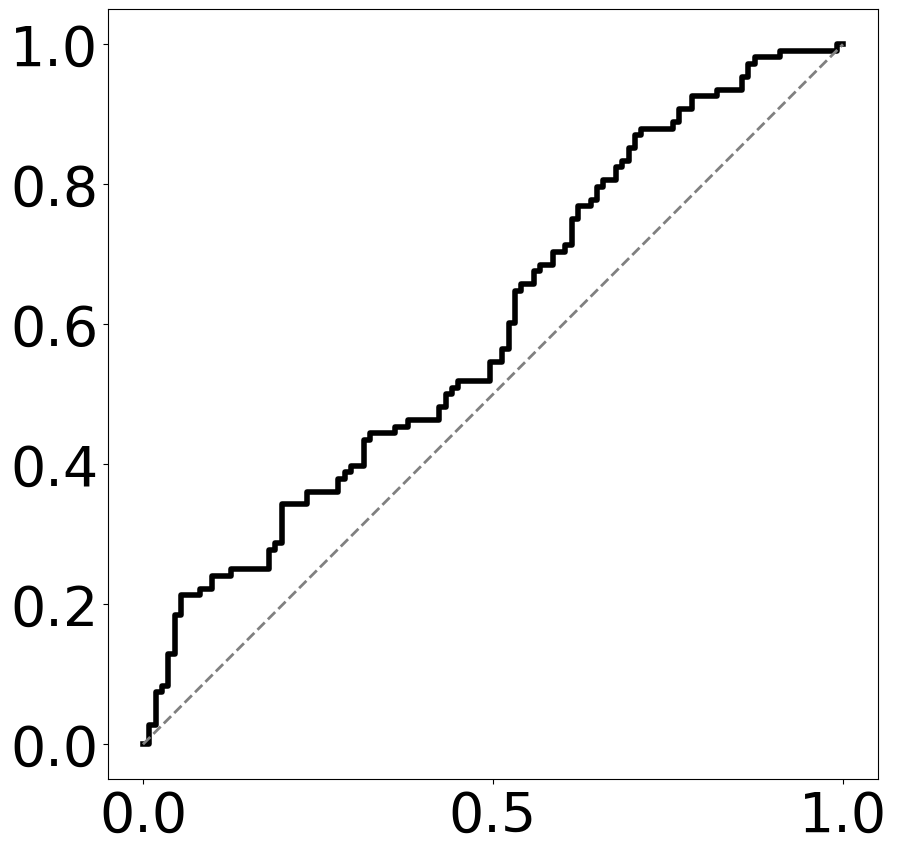

./Dataset_input/Covid/MG1655_mild_severe_LAG_GR_OD Size: (73, 3) Method: XGB Acc: 0.54±0.0171 AUC: 0.596(for 20-fold-CV and 3 iter) number of features: 4 cpu time 8.03


In [5]:
# Predict Patient condition using growth curves with selected features
# and plot ROC curve

import glob
from Library.Import    import *
from Library.Utilities import svm_classifier, MLP, XGB, GP 
from Library.Utilities import bayes_classifier, decision_tree_classifier
from Library.Utilities import LeaveXout, plot_ROC, read_XY
from sklearn.metrics   import mean_squared_error, accuracy_score

seed = 1
np.random.seed(seed=seed)
DIRECTORY = './'
xfold = 20
niter = 3
scoring_function=accuracy_score
learner = XGB
selection = 0
#filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_mild_severe_20_4'
#filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_mild_severe_20_10'
filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_mild_severe_LAG_GR_OD'
#filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_mild_severe_GR'
#filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_neg_pos_20_12'
#filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_neg_pos_LAG_GR_OD'
#filename = f'{DIRECTORY}Dataset_input/Covid/MG1655_neg_pos_GR'

feature, X, y = read_XY(filename)
y = y[:,0]    


# Train X, y for classification
start_time = time.time()
acc_avr, acc_dev, feature = LeaveXout(X, y.ravel(), feature, 
                                      learner=learner, 
                                      scoring_function=scoring_function, 
                                      xfold=xfold, niter=niter, 
                                      selection=selection,
                                      verbose=True)
delta_time = time.time() - start_time
F = np.array2string(feature).replace('[','').replace(']','')
auc = plot_ROC(X, y, learner, xfold=xfold, niter=niter, verbose=False)
print(f'{filename} Size: {X.shape} Method: {learner.__name__} '
      f'Acc: {acc_avr:.2f}±{acc_dev:.4f} AUC: {auc:.3f}'
      f'(for {xfold}-fold-CV and {niter} iter) '
      f'number of features: {len(feature)} cpu time {delta_time:.2f}')